In [1]:
from pathlib import Path
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

DATASET_ROOT = Path("dataset")

CLASS_ROOT = DATASET_ROOT / "classification_data"       # train/val/test live here
# VERI_DIR   = DATASET_ROOT / "verification_data"         # images for AUC
PAIRS_TXT  = DATASET_ROOT / "verification_pairs_val.txt"

train_tf = transforms.Compose([
    transforms.Resize(128), transforms.CenterCrop(112),
    transforms.RandomHorizontalFlip(), transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


def get_loader(split, batch=128, shuffle=True, workers=8):
    """
    split   : 'train', 'val', or 'test'
    batch   : mini-batch size
    workers : number of background CPU processes that feed the GPU
    """
    folder = CLASS_ROOT / f"{split}_data"
    ds = datasets.ImageFolder(folder, transform=train_tf)

    return DataLoader(
        ds,
        batch_size=batch,
        shuffle=shuffle,
        num_workers=workers,     # crank up until GPU util no longer improves
        pin_memory=True,         # faster CPU→GPU copies
        persistent_workers=True, # keep workers alive between epochs
        prefetch_factor=4        # each worker queues 4 batches ahead
    )

train_loader = get_loader("train", workers=8)
val_loader   = get_loader("val", shuffle=False, workers=8)
test_loader  = get_loader("test", shuffle=False, workers=8)

n_classes = len(train_loader.dataset.classes)
print("classes =", n_classes)


classes = 4000


In [2]:
import torch
print(torch.cuda.is_available())       # → True
print(torch.cuda.get_device_name(0))   # → NVIDIA GeForce RTX 3070 Laptop GPU
print(torch.version.cuda)              # → 12.1


True
NVIDIA GeForce RTX 3070 Laptop GPU
12.1


In [3]:
import pandas as pd
pairs = pd.read_csv(PAIRS_TXT, sep=" ", header=None,
                    names=["img1","img2","label"])
pairs["img1"] = pairs["img1"].apply(lambda p: DATASET_ROOT / p)
pairs["img2"] = pairs["img2"].apply(lambda p: DATASET_ROOT / p)
VERI_DIR = Path("verification_data")


In [4]:
import torch, torch.nn as nn
from torchvision.models import resnet18

device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision.models import ResNet18_Weights
net = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
                  # start from scratch
net.fc = nn.Linear(net.fc.in_features, n_classes)
net.to(device)

opt_cls  = torch.optim.Adam(net.parameters(), lr=1e-3)
ce   = nn.CrossEntropyLoss()


In [5]:
print("train images :", len(train_loader.dataset))
print("batch size   :", train_loader.batch_size)
print("batches/epoch:", len(train_loader))


train images : 380638
batch size   : 128
batches/epoch: 2974


In [ ]:
# ------------------------------------------------------------------
# 0.  Paths and helper
# ------------------------------------------------------------------
CKPT_DIR  = Path("models")
CKPT_FILE = CKPT_DIR / "resnet_face_cls_epoch10.pth"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

def load_classifier(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=device)
    net.load_state_dict(ckpt["model_state"])
    opt_cls.load_state_dict(ckpt["optimizer_state"])
    print(f"✅  Loaded classifier from {checkpoint_path} (val acc {ckpt['val_acc']:.3%})")

# ------------------------------------------------------------------
# 1.  Either load or train
# ------------------------------------------------------------------
if CKPT_FILE.exists():
    load_classifier(CKPT_FILE)

else:
    from tqdm import tqdm

    EPOCHS = 10
    for epoch in range(EPOCHS):
        net.train()
        for x, y in tqdm(train_loader, desc=f"epoch {epoch}"):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            opt_cls.zero_grad()
            ce(net(x), y).backward()
            opt_cls.step()

        # quick val accuracy
        net.eval(); correct = total = 0
        with torch.no_grad():
            for x, y in val_loader:
                preds = net(x.to(device)).argmax(1)
                correct += (preds.cpu() == y).sum().item()
                total   += y.size(0)
        val_acc = correct / total
        print(f"epoch {epoch}: val acc = {val_acc:.3%}")

    # save once, after the final epoch
    torch.save({
        "epoch": epoch,
        "model_state": net.state_dict(),
        "optimizer_state": opt_cls.state_dict(),
        "val_acc": val_acc
    }, CKPT_FILE)
    print("💾  Saved classifier to", CKPT_FILE)



✅  Loaded classifier from checkpoints\resnet_face_cls_epoch10.pth (val acc 63.513%)


C:\Users\terif\AppData\Local\Temp\ipykernel_12272\699632080.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


In [7]:
class EmbNet(nn.Module):
    def __init__(self, dim=256):
        super().__init__()
        from torchvision.models import ResNet18_Weights
        self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Identity()          # strip classifier
        self.fc = nn.Linear(512, dim)             # learnable projection


    def forward(self,x):
        z = self.backbone(x)
        z = nn.functional.normalize(self.fc(z))   # ℓ2-norm
        return z

emb_net = EmbNet().to(device)
opt_emb = torch.optim.Adam(emb_net.parameters(), lr=1e-4)
triplet = nn.TripletMarginLoss(margin=0.2)

# --- tiny helper that yields (anchor,positive,negative) batches ------------
from itertools import combinations
import random
def triplet_loader(loader):
    while True:
        for imgs,labels in loader:
            imgs,labels = imgs.to(device), labels.to(device)
            idx_by_cls = {c: (labels==c).nonzero(as_tuple=True)[0]
                          for c in labels.unique()}
            anchors, positives, negatives = [], [], []
            for c,(iidx) in idx_by_cls.items():
                if len(iidx)<2: continue
                a,p = iidx[:2]                      # first two same-class
                ncls = random.choice([k for k in idx_by_cls if k!=c])
                n = idx_by_cls[ncls][0]
                anchors.append(imgs[a]); positives.append(imgs[p]); negatives.append(imgs[n])
            if anchors:
                yield torch.stack(anchors), torch.stack(positives), torch.stack(negatives)


In [8]:
# ---------------------------------------------------------------
# Helper: batch-all triplet loss (on-GPU mining, no Python loops)
# ---------------------------------------------------------------
def batch_all_triplet_loss(emb, labels, margin=0.2):
    """
    emb    : (B, D) L2-normalised embeddings
    labels : (B,)   class indices
    returns scalar loss
    """
    # cosine distance (1 - cosine similarity)
    dist = 1 - emb @ emb.T                       # (B,B)

    same   = labels.unsqueeze(0) == labels.unsqueeze(1)  # (B,B) bool
    diff   = ~same

    # drop self-pairs from positives
    dist_pos = dist.masked_select(same ^ torch.eye(len(labels), dtype=torch.bool, device=labels.device))
    dist_pos = dist_pos.view(len(labels), -1)            # (B, P)

    # for each anchor pick the *hardest* (min-distance) negative in the batch
    dist_neg = dist.masked_select(diff).view(len(labels), -1)  # (B, N)
    hardest_neg = dist_neg.min(dim=1, keepdim=True).values     # (B,1)

    loss = torch.clamp(dist_pos - hardest_neg + margin, min=0.)
    return loss.mean()


In [ ]:
# ------------------------------------------------------------------
# 0.  Paths and helper for triplet model
# ------------------------------------------------------------------
CKPT_EMB = Path("models/embnet_triplet_15k.pth")

def load_embnet(path):
    ckpt = torch.load(path, map_location=device)
    emb_net.load_state_dict(ckpt["model_state"])
    opt_emb.load_state_dict(ckpt["optimizer_state"])
    print(f"✅  Loaded EmbNet ({ckpt['steps']} steps, loss {ckpt['loss']:.4f})")

# ------------------------------------------------------------------
# 1.  Either load or train
# ------------------------------------------------------------------
if CKPT_EMB.exists():
    load_embnet(CKPT_EMB)

else:
    tri_gen = triplet_loader(train_loader)
    NUM_STEPS = 15_000
    for step in range(1, NUM_STEPS + 1):
        a, p, n = next(tri_gen)
        opt_emb.zero_grad()
        loss = triplet(emb_net(a), emb_net(p), emb_net(n))
        loss.backward()
        opt_emb.step()
        if step % 500 == 0:
            print(f"step {step}, loss {loss.item():.4f}")

    # save once after finishing all steps
    torch.save({
        "steps": NUM_STEPS,
        "model_state": emb_net.state_dict(),
        "optimizer_state": opt_emb.state_dict(),
        "loss": loss.item()
    }, CKPT_EMB)
    print("💾  Saved EmbNet to", CKPT_EMB)


step 500, loss 0.2001
step 1000, loss 0.1449
step 1500, loss 0.1481
step 2000, loss 0.0268
step 2500, loss 0.2415
step 3000, loss 0.0897
step 3500, loss 0.1831
step 4000, loss 0.0000
step 4500, loss 0.0000
step 5000, loss 0.2395
step 5500, loss 0.1023
step 6000, loss 0.3000
step 6500, loss 0.0000
step 7000, loss 0.0299
step 7500, loss 0.0093
step 8000, loss 0.0000
step 8500, loss 0.0815
step 9000, loss 0.0000
step 9500, loss 0.1382
step 10000, loss 0.0000
step 10500, loss 0.0597
step 11000, loss 0.0000
step 11500, loss 0.0000
step 12000, loss 0.0648
step 12500, loss 0.0000
step 13000, loss 0.0989
step 13500, loss 0.2020
step 14000, loss 0.1761
step 14500, loss 0.1451
step 15000, loss 0.0000
💾  Saved EmbNet to checkpoints\embnet_triplet_15k.pth


In [10]:
from torch.utils.data import DataLoader
from torchvision.datasets.folder import default_loader   # PIL opener
from pathlib import Path

VERI_DIR = DATASET_ROOT / "verification_data"            # absolute dir

# ---------------- dataset -----------------------------------------
class VeriSet(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.paths     = list(root.rglob("*.jpg"))
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = default_loader(self.paths[idx])            # PIL image
        return self.transform(img), self.paths[idx]      # (tensor, Path)

# ---------------- custom collate  ---------------------------------
def collate_fn(batch):
    imgs, paths = zip(*batch)                 # two tuples
    imgs  = torch.stack(imgs, 0)              # (B,3,112,112) tensor
    paths = list(paths)                       # keep Paths as-is
    return imgs, paths

# ---------------- loader ------------------------------------------
veri_ds     = VeriSet(VERI_DIR, train_tf)
veri_loader = DataLoader(
    veri_ds,
    batch_size=128,
    shuffle=False,
    num_workers=0,          # single process is fine for cached images
    pin_memory=True,
    collate_fn=collate_fn   # ← key addition
)

relkey = lambda p: str(p.relative_to(DATASET_ROOT))      # helper

# ---------------- embed & cache -----------------------------------
emb_cache = {}
emb_net.eval()
# 1. build the cache with relative-string keys
with torch.no_grad():
    for batch, paths in veri_loader:
        batch = batch.to(device, non_blocking=True)
        vecs  = emb_net(batch).cpu()
        for p, v in zip(paths, vecs):
            emb_cache[relkey(p)] = v


In [11]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

scores, labels = [], []
for _, r in pairs.iterrows():
    v1 = emb_cache[relkey(r.img1)]
    v2 = emb_cache[relkey(r.img2)]
    sim = F.cosine_similarity(v1, v2, dim=0)   # ← specify dim=0
    scores.append(sim.item())
    labels.append(r.label)

print("AUC =", roc_auc_score(labels, scores))



AUC = 0.7921587821010769


In [12]:
# -----------------------------------------------
# helper to extract 512-d features from 'net'
# -----------------------------------------------
class ClassifierFeats(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.backbone = nn.Sequential(*list(model.children())[:-1])  # everything but FC
    def forward(self, x):
        x = self.backbone(x)            # (B,512,1,1)
        x = torch.flatten(x, 1)         # (B,512)
        return torch.nn.functional.normalize(x, dim=1)

cls_feat = ClassifierFeats(net).to(device).eval()

# build a second cache
cls_cache = {}
with torch.no_grad():
    for batch, paths in veri_loader:
        batch = batch.to(device, non_blocking=True)
        vecs  = cls_feat(batch).cpu()            # (B,512)
        for p, v in zip(paths, vecs):
            cls_cache[relkey(p)] = v

# compute AUC
scores_cls, labels = [], []
for _, r in pairs.iterrows():
    v1 = cls_cache[relkey(r.img1)]
    v2 = cls_cache[relkey(r.img2)]
    scores_cls.append(F.cosine_similarity(v1, v2, dim=0).item())
    labels.append(r.label)

print("Classifier-embedding AUC =", roc_auc_score(labels, scores_cls))


Classifier-embedding AUC = 0.8816377323626341


In [13]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# ------------ classifier -----------------
fpr_cls, tpr_cls, _ = roc_curve(labels, scores_cls)
auc_cls = auc(fpr_cls, tpr_cls)

# ------------ triplet embedding ----------
fpr_emb, tpr_emb, _ = roc_curve(labels, scores)
auc_emb = auc(fpr_emb, tpr_emb)

print(f"Classifier AUC  : {auc_cls:.4f}")
print(f"Triplet  AUC    : {auc_emb:.4f}")


Classifier AUC  : 0.8816
Triplet  AUC    : 0.7922


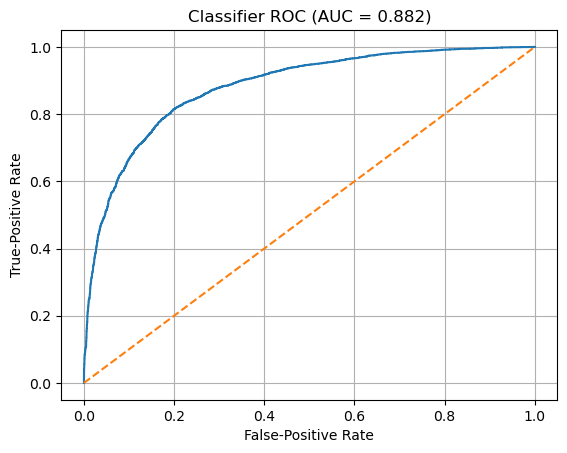

In [14]:
import matplotlib.pyplot as plt

plt.figure()                       # one dedicated figure
plt.plot(fpr_cls, tpr_cls)
plt.plot([0, 1], [0, 1], linestyle="--")   # random-guess line
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title(f"Classifier ROC (AUC = {auc_cls:.3f})")
plt.grid(True)
plt.show()


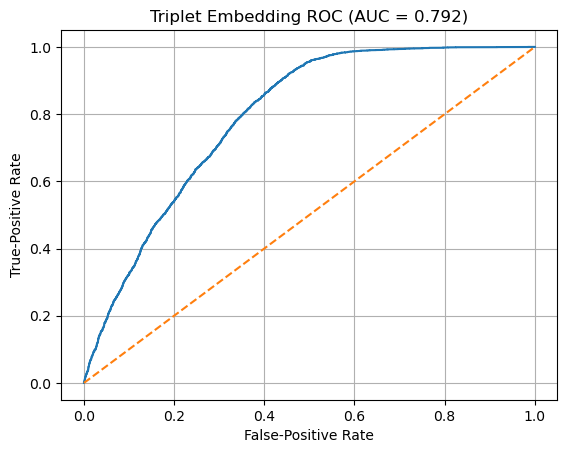

In [15]:
plt.figure()                       # separate figure
plt.plot(fpr_emb, tpr_emb)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title(f"Triplet Embedding ROC (AUC = {auc_emb:.3f})")
plt.grid(True)
plt.show()


In [16]:
# %%  Euclidean AUC for classifier embeddings
scores_cls_euc, labels_cls = [], []
for _, r in pairs.iterrows():
    v1 = cls_cache[relkey(r.img1)]
    v2 = cls_cache[relkey(r.img2)]
    sim = -torch.norm(v1 - v2, p=2).item()   # negative so "higher is more similar"
    scores_cls_euc.append(sim)
    labels_cls.append(r.label)

auc_cls_euc = roc_auc_score(labels_cls, scores_cls_euc)
print(f"Classifier AUC (Euclidean) = {auc_cls_euc:.4f}")


Classifier AUC (Euclidean) = 0.8816


In [17]:
# %%  Euclidean-distance baseline
from sklearn.metrics import roc_auc_score

scores_euc, labels_euc = [], []
for _, r in pairs.iterrows():
    v1 = emb_cache[relkey(r.img1)]
    v2 = emb_cache[relkey(r.img2)]

    # negative Euclidean distance (higher = more similar)
    sim_euc = -torch.norm(v1 - v2, p=2).item()
    scores_euc.append(sim_euc)
    labels_euc.append(r.label)

auc_euc = roc_auc_score(labels_euc, scores_euc)
print(f"AUC (Euclidean) = {auc_euc:.4f}")


AUC (Euclidean) = 0.7922


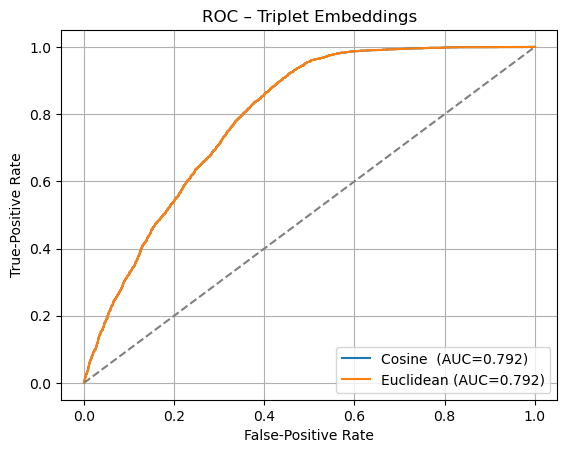

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# cosine (already have scores / labels)
fpr_c, tpr_c, _ = roc_curve(labels, scores)
auc_c = auc(fpr_c, tpr_c)

# euclidean
fpr_e, tpr_e, _ = roc_curve(labels_euc, scores_euc)
auc_e = auc(fpr_e, tpr_e)

plt.figure()
plt.plot(fpr_c, tpr_c, label=f"Cosine  (AUC={auc_c:.3f})")
plt.plot(fpr_e, tpr_e, label=f"Euclidean (AUC={auc_e:.3f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC – Triplet Embeddings")
plt.legend()
plt.grid(True)
plt.show()


Classifier AUC (Euclidean) = 0.8816


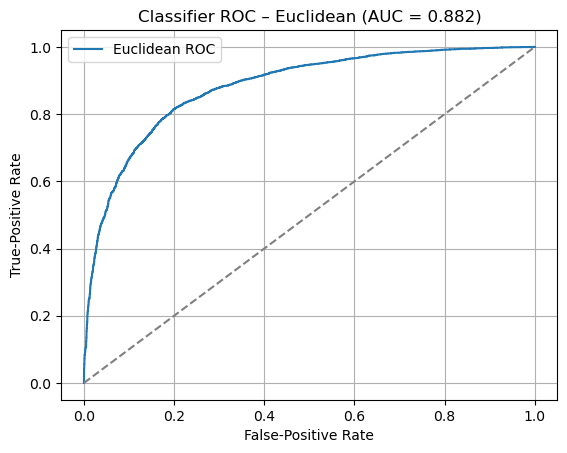

In [19]:
# %%  --  ROC curve for classifier embeddings (Euclidean distance)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- if you haven't run the Euclidean-score loop yet, do that first ---
# scores_cls_euc, labels_cls already exist if you ran the earlier cell

fpr_e, tpr_e, _ = roc_curve(labels_cls, scores_cls_euc)
auc_e           = auc(fpr_e, tpr_e)
print(f"Classifier AUC (Euclidean) = {auc_e:.4f}")

plt.figure()                                # one dedicated plot
plt.plot(fpr_e, tpr_e, label="Euclidean ROC")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title(f"Classifier ROC – Euclidean (AUC = {auc_e:.3f})")
plt.grid(True)
plt.legend()
plt.show()
